In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re

%matplotlib inline

In [2]:
df = pd.read_csv("/home/paradox/data/sentiment/train.csv", encoding = "ISO-8859-1")

In [3]:
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [4]:
df.shape

(99989, 3)

In [5]:
df = df[['Sentiment', 'SentimentText']]

In [6]:
df.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [40]:
df['Sentiment'].describe()

count    99989.000000
mean         0.564632
std          0.495808
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Sentiment, dtype: float64

In [43]:
df['Sentiment'].value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

## Preprocess Text
- Remove Emoticon
- Remove Twitter handle username, urls...
- Remove unwanted characters 
- Expand common acronyms like we'll, they're
- Remove stopwords

In [7]:
from preprocess import clean_all, remove_stopwords
from data import load_emoticons

from nltk.stem import WordNetLemmatizer

In [8]:
def lemmatize(tokens, lemmatizer):
    return ' '.join([ wordnet_lemmatizer.lemmatize(token, pos='v') for token in tokens ])

In [9]:
stopwords = set(nltk.corpus.stopwords.words('english'))
len(stopwords)

179

In [10]:
emoticons = load_emoticons("data/emoticons.txt")
len(emoticons)

134

In [11]:
df['text'] = df['SentimentText'].apply(lambda x: clean_all(x, emoticons, stopwords, remove_stop=True))

In [12]:
df['text'].head()

0                                       sad apl friend
1                              missed new moon trailer
2                                          omg already
3    <SENTENCE> omgaga <SENTENCE> im sooo im gunna ...
4                      think mi bf cheating <SENTENCE>
Name: text, dtype: object

In [13]:
df['text'] = df['text'].str.replace(r'(<SENTENCE>)|(<EMOTICON>)', ' ', regex=True)
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

In [14]:
df['text'].head()

0                                       sad apl friend
1                              missed new moon trailer
2                                          omg already
3     omgaga im sooo im gunna cry dentist since sup...
4                                think mi bf cheating 
Name: text, dtype: object

In [15]:
wordnet_lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x : lemmatize(x.split(), wordnet_lemmatizer))

In [16]:
df['text'].head()

0                                       sad apl friend
1                                miss new moon trailer
2                                          omg already
3    omgaga im sooo im gunna cry dentist since supo...
4                                    think mi bf cheat
Name: text, dtype: object

## Feature Extraction

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], 
                                                    df['Sentiment'], 
                                                    train_size=0.9,
                                                )

In [77]:
X_train.shape, Y_train.shape

((89990,), (89990,))

In [78]:
X_test.shape, Y_test.shape

((9999,), (9999,))

In [79]:
Y_train.value_counts()

1    50880
0    39110
Name: Sentiment, dtype: int64

In [80]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words='english'
)

In [81]:
X_train = vectorizer.fit_transform(X_train)

In [82]:
X_train.shape

(89990, 338936)

In [83]:
X_test = vectorizer.transform(X_test)

In [84]:
X_test.shape

(9999, 338936)

## Classification

In [85]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [86]:
model = MultinomialNB(alpha=0.8)
# model = RandomForestClassifier()

In [87]:
model.fit(X_train, Y_train)

MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)

## Evaluation

In [88]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

In [89]:
Y_pred = model.predict(X_test)
Y_pred.shape

(9999,)

In [90]:
accuracy_score(Y_test, Y_pred)

0.7179717971797179

In [91]:
cm = confusion_matrix(Y_test, Y_pred)

In [92]:
cm

array([[2249, 2173],
       [ 647, 4930]])

In [93]:
import seaborn as sns

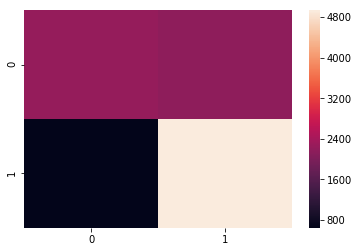

In [94]:
sns.heatmap(cm)

Text(0.5, 15.0, 'Predicted label')

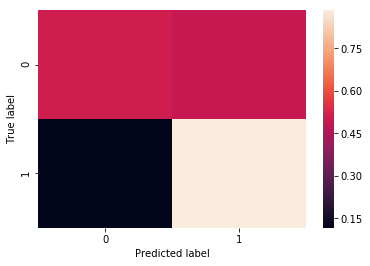

In [95]:
conf_mat_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Use Sentiment Model on Personal Tweet

In [123]:
data = pd.read_csv("data/tweets/clean/clean.csv").dropna()

In [124]:
data['created_at'] = pd.to_datetime(data['created_at'])

In [125]:
data.head()

,created_at,text
0,2014-06-07 04:58:36,what pride therein lied the salvated victim of...
1,2014-06-02 15:59:11,game of life simple yet complex
2,2014-06-01 16:38:18,well well <SENTENCE> who do we have here <SENT...
3,2014-06-01 16:31:18,paradox indeed <SENTENCE> d
4,2014-06-01 12:49:22,i exist <SENTENCE> therefore i may not exist


In [126]:
data['text'] = data['text'].apply(lambda x: clean_all(x, emoticons, stopwords, remove_stop=True))
data['text'] = data['text'].str.replace(r'(<SENTENCE>)|(<EMOTICON>)', ' ', regex=True)
data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True)
wordnet_lemmatizer = WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x : lemmatize(x.split(), wordnet_lemmatizer))

In [127]:
data.head()

,created_at,text
0,2014-06-07 04:58:36,pride therein lie salvated victim mind
1,2014-06-02 15:59:11,game life simple yet complex
2,2014-06-01 16:38:18,well well paradox back town p
3,2014-06-01 16:31:18,paradox indeed
4,2014-06-01 12:49:22,exist therefore may exist


In [128]:
features = vectorizer.transform(data['text'])

In [129]:
features.shape

(13081, 338936)

In [130]:
data['sentiment_prediction'] = model.predict(features)

In [131]:
data.head()

,created_at,text,sentiment_prediction
0,2014-06-07 04:58:36,pride therein lie salvated victim mind,1
1,2014-06-02 15:59:11,game life simple yet complex,1
2,2014-06-01 16:38:18,well well paradox back town p,1
3,2014-06-01 16:31:18,paradox indeed,1
4,2014-06-01 12:49:22,exist therefore may exist,1


In [132]:
data.shape

(13081, 3)

In [133]:
data['sentiment_prediction'].describe()

count    13081.000000
mean         0.862855
std          0.344014
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sentiment_prediction, dtype: float64

In [134]:
data.groupby(['sentiment_prediction']).count()

,created_at,text
sentiment_prediction,,
0,1794,1794
1,11287,11287


## Analyze Prediction

In [135]:
data2 = data.sort_values(by='created_at')

In [136]:
data2.head()

,created_at,text,sentiment_prediction
4,2014-06-01 12:49:22,exist therefore may exist,1
3,2014-06-01 16:31:18,paradox indeed,1
2,2014-06-01 16:38:18,well well paradox back town p,1
1,2014-06-02 15:59:11,game life simple yet complex,1
0,2014-06-07 04:58:36,pride therein lie salvated victim mind,1


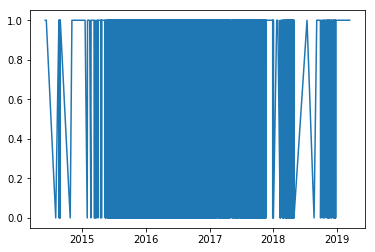

In [137]:
plt.plot(data2['created_at'], data2['sentiment_prediction'])

In [138]:
from nltk import FreqDist

In [146]:
prediction_group = data2.groupby('sentiment_prediction')

In [147]:
negatives = prediction_group.get_group(0)

In [148]:
negatives.head()

,created_at,text,sentiment_prediction
5,2014-07-31 09:55:17,mario cover worst,0
46,2014-08-19 16:35:14,new phrase embed quantum brain quantum vacuum ...,0
35,2014-08-23 15:51:30,go swing copters,0
13,2014-08-26 12:50:17,rip discrete,0
10,2014-08-26 13:15:45,cuz deepness make u forget shit reality system,0


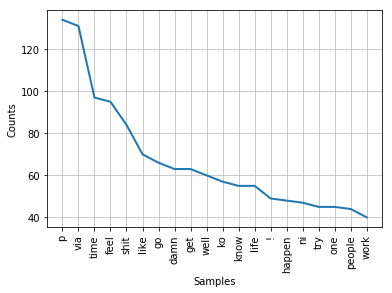

In [151]:
text = ' '.join(negatives['text'].values)
tokens = nltk.word_tokenize(text)
freq = FreqDist(tokens)
freq.plot(20, cumulative=False)

In [152]:
positives = prediction_group.get_group(1)

In [150]:
positives.head()

,created_at,text,sentiment_prediction
4,2014-06-01 12:49:22,exist therefore may exist,1
3,2014-06-01 16:31:18,paradox indeed,1
2,2014-06-01 16:38:18,well well paradox back town p,1
1,2014-06-02 15:59:11,game life simple yet complex,1
0,2014-06-07 04:58:36,pride therein lie salvated victim mind,1


In [ ]:
text = ' '.join(positives['text'].values)
tokens = nltk.word_tokenize(text)
freq = FreqDist(tokens)
freq.plot(20, cumulative=False)